<a href="https://colab.research.google.com/github/CWill22/NeuralHW3/blob/main/Will_Curry_XOR_FCN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

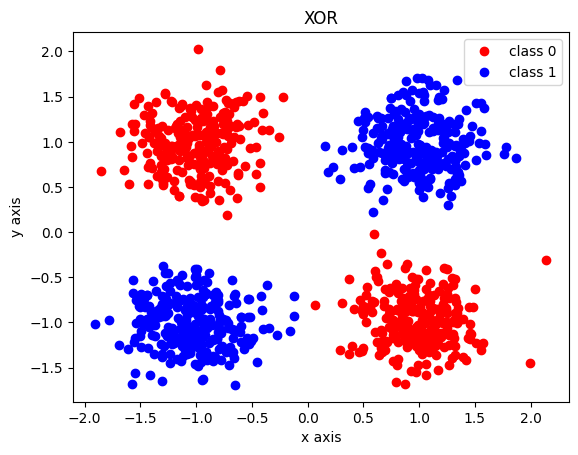

In [18]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)
X = rng.randn(1000, 2)
X = (X > 0) * 2 - 1 + 0.3 * rng.randn(*X.shape)
Y = np.logical_xor(X[:,0] > 0, X[:,1] > 0).astype(int)

c0 = X[np.nonzero(Y)[0]]
c1 = X[np.nonzero(Y == 0)[0]]

plt.plot(c0[:,0], c0[:,1], 'ro', label='class 0')
plt.plot(c1[:,0], c1[:,1], 'bo', label='class 1')

plt.title('XOR')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.legend()
plt.show()

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size=8

training_data = DataLoader(TensorDataset(torch.Tensor(X[:750,:]), torch.tensor(Y[:750], dtype=torch.long)), shuffle=True, batch_size=batch_size)
validation_data = DataLoader(TensorDataset(torch.Tensor(X[750:,:]), torch.tensor(Y[750:], dtype=torch.long)), batch_size=batch_size)

In [20]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.activation = nn.ReLU()
        #self.first_hidden = nn.Linear(2, 10)
        self.first_hidden = nn.Linear(2, 2)
        #self.second_hidden = nn.Linear(10, 5)
        self.output = nn.Linear(2, 2)

    def forward(self, x):
        x = self.activation(self.first_hidden(x))
        #x = self.activation(self.second_hidden(x))
        x = self.output(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (activation): ReLU()
  (first_hidden): Linear(in_features=2, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=2, bias=True)
)


In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [23]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [24]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data, model, loss_fn, optimizer)
    test(validation_data, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.696841  [    0/  750]
Test Error: 
 Accuracy: 49.6%, Avg loss: 0.641152 

Epoch 2
-------------------------------
loss: 0.659452  [    0/  750]
Test Error: 
 Accuracy: 68.8%, Avg loss: 0.561042 

Epoch 3
-------------------------------
loss: 0.517229  [    0/  750]
Test Error: 
 Accuracy: 71.6%, Avg loss: 0.499192 

Epoch 4
-------------------------------
loss: 0.415108  [    0/  750]
Test Error: 
 Accuracy: 73.2%, Avg loss: 0.413532 

Epoch 5
-------------------------------
loss: 0.303977  [    0/  750]
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.326420 

Epoch 6
-------------------------------
loss: 0.477405  [    0/  750]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.254162 

Epoch 7
-------------------------------
loss: 0.151521  [    0/  750]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.202032 

Epoch 8
-------------------------------
loss: 0.165911  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.160654 

Epoch 9
----------------

In [25]:
def predict(x):
    #Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor).to(device)
    #Predict and return ans
    ans = torch.argmax(model(x), dim=1)
    return ans.to('cpu').detach().numpy()

In [26]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func,X,Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.title('XOR')
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    # Plot ground truth
    c0 = X[np.nonzero(Y)[0]]
    c1 = X[np.nonzero(Y == 0)[0]]
    plt.plot(c0[:,0], c0[:,1], 'ko', label='class 0')
    plt.plot(c1[:,0], c1[:,1], 'wo', label='class 1')
    plt.legend()

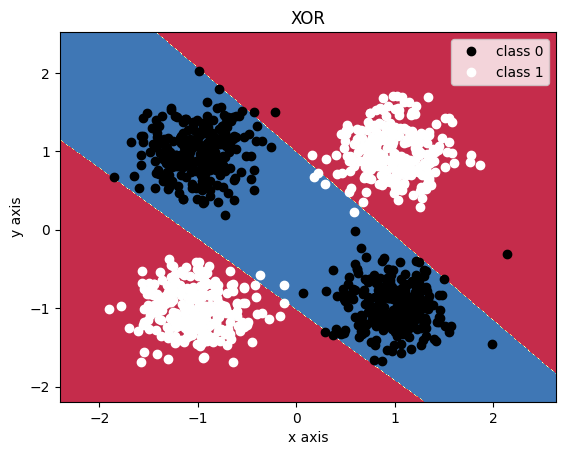

In [27]:
plot_decision_boundary(predict, X, Y)